In [1]:
import random
from pathlib import Path

import numpy as np
import torch
from sklearn.metrics import (mean_absolute_percentage_error,
                             root_mean_squared_error)

from forecast import load_data, train, validate
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

In [4]:
(sc, train_size, test_size, data, dataX, dataY, trainX, trainY, testX, testY) = load_data(
    base_path=Path('./data/dfyj/key5_20240618_20240718'),
    ip='8.27.105.214'
)

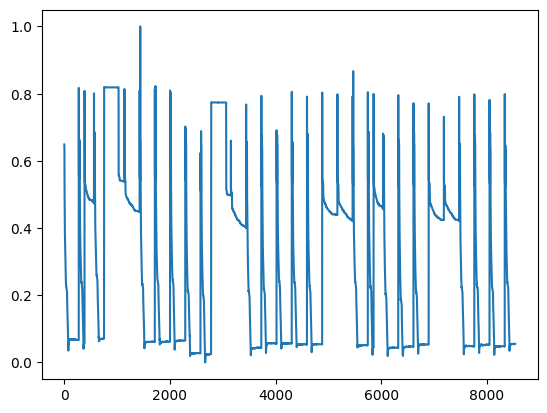

In [5]:
plt.plot(data)

In [6]:
lstm = train(trainX=trainX, trainY=trainY, lr=1e-2,
             num_epochs=50, hidden_size=32)

Loss: 0.0014679019805043936: 100%|██████████| 50/50 [03:09<00:00,  3.79s/it]


In [7]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

print('Test RMSE: %.5f' % root_mean_squared_error(dataY_plot, data_predict))
print('Test MAPE: %.5f' %
      mean_absolute_percentage_error(dataY_plot, data_predict))

Test RMSE: 0.03939
Test MAPE: 0.03887


In [14]:
data_alt = load_data(
    Path('./data/dfyj/key1_20240618_20240718'),
    "8.27.107.86"
)

dataX_alt = data_alt[3]
dataY_alt = data_alt[4]

lstm.eval()
validate(dataX_alt, dataY_alt, lstm)

MAPE: 0.30061710609286785
RMSE: 0.2094939649105072


In [13]:
data_alt = load_data(
    Path('./data/dfyj/key5_20240618_20240718'),
    "8.27.109.214"
)

dataX_alt = data_alt[3]
dataY_alt = data_alt[4]

lstm.eval()
validate(dataX_alt, dataY_alt, lstm)

MAPE: 0.15167640708226957
RMSE: 0.13360147178173065


In [25]:
data_alt = load_data(
    Path('./data/dfyj/key1_20240618_20240718'),
    "8.29.41.86"
)

dataX_alt = data_alt[3]
dataY_alt = data_alt[4]

lstm.eval()
validate(dataX_alt, dataY_alt, lstm)

MAPE: 8.65402847787868
RMSE: 0.6603192090988159
